# i. Introduction


>Latar Belakang : 

Bank ingin lebih memahami perilaku dan kebiasaan pengguna kartu kredit, Bank ini mengumpulkan data pengguna kartu kredit selama 6 bulan tentang kebiasaan dan preferensi pengguna, yang dapat membantu bank dalam menyusun strategi pemasaran yang lebih efektif dan menyediakan layanan yang lebih sesuai dengan kebutuhan pelanggan. Kemudian bank ini memberikan data kepada saya yang seorang data science agar dapat mengkategorikan pengguna kartu kredit.

>Obejective :

Proyek ini ingin membangun model clustering untuk melakukan Customer Segmentation dari data kartu kredit bank ini. Dengan cara membuat `model clustering`  dengan K-MEANS sehingga nantinya bank dapat mengetahui lelompok-kelompok yang memiliki karakteristik perilaku yang serupa. Dengan demikian, bank dapat menyesuaikan strategi pemasaran dan layanan secara lebih spesifik sesuai dengan kebutuhan dan preferensi dari setiap segmen pelanggan.

Data description:

| Column                            | Description                                                                                       |
|-----------------------------------|---------------------------------------------------------------------------------------------------|
| `CUST_ID`                         | Identification of Credit Card holder (Categorical)                                                |
| `BALANCE`                         | Balance amount left in their account to make purchases                                            |
| `BALANCE_FREQUENCY`               | How frequently the Balance is updated, score between 0 and 1 (1 = frequently updated, 0 = not frequently updated) |
| `PURCHASES`                       | Amount of purchases made from account                                                             |
| `ONEOFF_PURCHASES`                | Maximum purchase amount done in one-go                                                            |
| `INSTALLMENTS_PURCHASES`          | Amount of purchase done in installment                                                            |
| `CASH_ADVANCE`                    | Cash in advance given by the user                                                                 |
| `PURCHASES_FREQUENCY`             | How frequently the Purchases are being made, score between 0 and 1 (1 = frequently purchased, 0 = not frequently purchased) |
| `ONEOFF_PURCHASES_FREQUENCY`      | How frequently Purchases are happening in one-go (1 = frequently purchased, 0 = not frequently purchased) |
| `PURCHASES_INSTALLMENTS_FREQUENCY`| How frequently purchases in installments are being done (1 = frequently done, 0 = not frequently done) |
| `CASH_ADVANCE_FREQUENCY`          | How frequently the cash in advance being paid                                                     |
| `CASH_ADVANCE_TRX`                | Number of Transactions made with "Cash in Advanced"                                               |
| `PURCHASES_TRX`                   | Number of purchase transactions made                                                              |
| `CREDIT_LIMIT`                    | Limit of Credit Card for user                                                                     |
| `PAYMENTS`                        | Amount of Payment done by user                                                                    |
| `MINIMUM_PAYMENTS`                | Minimum amount of payments made by user                                                           |
| `PRC_FULL_PAYMENT`                | Percent of full payment paid by user                                                              |
| `TENURE`                          | Tenure of credit card service for user                                                            |


# ii. SQL

```SQL
from google.colab import auth
from google.cloud import bigquery
auth.authenticate_user()
print('Authenticated')

project_id_akun = "mythical-plate-417802"
client = bigquery.Client(project=project_id_akun)
```

```SQL
df = client.query('''
SELECT
  CUST_ID,
  BALANCE,  
  BALANCE_FREQUENCY,
  PURCHASES,
  ONEOFF_PURCHASES,
  INSTALLMENTS_PURCHASES,
  CASH_ADVANCE,
  PURCHASES_FREQUENCY,
  ONEOFF_PURCHASES_FREQUENCY,
  PURCHASES_INSTALLMENTS_FREQUENCY,
  CASH_ADVANCE_FREQUENCY,
  CASH_ADVANCE_TRX,
  PURCHASES_TRX,
  CREDIT_LIMIT,
  PAYMENTS,
  MINIMUM_PAYMENTS,
  PRC_FULL_PAYMENT,
  TENURE,
FROM `ftds-hacktiv8-project.phase1_ftds_005_bsd.credit-card-information`
WHERE MOD(CUST_ID, 2) =1
''').to_dataframe()
```

Save the DataFrame to a CSV file  
`
df.to_csv('DataSet.csv', index=False)
`

# iii. Import Libraries

In [1]:
# libraries
import pandas as pd
import numpy as np

# membuat grafik/visualisasi
import matplotlib.pyplot as plt
import seaborn as sns

# import FE
## Handling outliers
from feature_engine.outliers import Winsorizer

## feature scaling
from sklearn.preprocessing import MinMaxScaler

## reduksi dimenadi
from sklearn.decomposition import PCA

# model
from sklearn.cluster import KMeans
import matplotlib.cm as cm
from sklearn.metrics import silhouette_score, silhouette_samples

# saving model
import pickle
import json

# agar tidak muncul warning
import warnings
warnings.filterwarnings("ignore")

# iv. Data Loading

In [2]:
# mengimport data csv ke notebook
df_ori = pd.read_csv('DataSet.csv')

# duplicate dataset
df = df_ori.copy()

In [3]:
# menampilkan data 10 teratas
df.head(10)

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,3091,3.833185,0.125000,45.00,45.00,0.00,0.0,0.125,0.125,0.00,0.0,0,1,500.0,0.000000,NaN,0.000000,8
1,5069,0.000000,0.000000,176.03,176.03,0.00,0.0,0.125,0.125,0.00,0.0,0,1,7000.0,0.000000,NaN,0.000000,8
2,6075,757.964752,0.875000,157.40,157.40,0.00,0.0,0.125,0.125,0.00,0.0,0,6,1200.0,1494.480376,2638.598410,0.000000,8
3,6291,264.566591,0.375000,1150.00,1150.00,0.00,0.0,0.125,0.125,0.00,0.0,0,1,1200.0,3029.380326,85.428885,0.000000,8
4,7755,440.613643,1.000000,600.00,600.00,0.00,0.0,0.125,0.125,0.00,0.0,0,1,1000.0,215.316424,137.846006,0.000000,8
5,8299,611.561026,1.000000,765.00,765.00,0.00,0.0,0.125,0.125,0.00,0.0,0,1,2000.0,204.464151,146.352314,0.000000,8
6,8629,0.228572,0.125000,60.00,60.00,0.00,0.0,0.125,0.125,0.00,0.0,0,1,1500.0,438.738982,NaN,0.000000,8
7,8805,105.333584,0.375000,306.00,306.00,0.00,0.0,0.125,0.125,0.00,0.0,0,2,6000.0,101.986927,118.324082,0.000000,8
8,7,16.379412,0.454545,178.15,0.00,178.15,0.0,0.250,0.000,0.25,0.0,0,3,5000.0,229.376368,89.613822,0.181818,12
9,91,559.151424,1.000000,94.00,94.00,0.00,0.0,0.250,0.250,0.00,0.0,0,3,5500.0,254.733329,218.279194,0.000000,12


In [4]:
# menampilkan data 10 terbawah
df.tail(10)

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
4465,6809,4438.521324,1.000000,591.84,109.16,482.68,564.365429,0.636364,0.181818,0.454545,0.272727,3,11,17000.0,5552.601399,1094.486286,0.00,11
4466,7211,1135.703750,1.000000,92.07,0.00,92.07,81.509491,0.272727,0.000000,0.181818,0.272727,3,3,1200.0,355.798199,434.689529,0.00,11
4467,8295,185.984965,0.454545,482.24,392.24,90.00,903.843591,0.272727,0.181818,0.090909,0.272727,8,8,1200.0,2333.997439,160.900585,0.25,11
4468,8855,3531.167073,0.900000,797.50,577.83,219.67,5273.226918,0.700000,0.400000,0.500000,0.900000,33,21,4000.0,2979.546700,3052.080103,0.00,10
4469,2389,1917.895730,1.000000,285.07,285.07,0.00,6084.858872,0.363636,0.363636,0.000000,1.090909,28,6,3000.0,5692.682993,556.449635,0.00,11
4470,2345,9629.808851,1.000000,0.00,0.00,0.00,4372.393835,0.000000,0.000000,0.000000,0.545455,9,0,12000.0,2468.988022,2134.295731,0.00,11
4471,6785,1040.030221,1.000000,0.00,0.00,0.00,1390.648290,0.000000,0.000000,0.000000,0.545455,18,0,1400.0,290.129620,287.994171,0.00,11
4472,7347,1322.818587,1.000000,0.00,0.00,0.00,762.301096,0.000000,0.000000,0.000000,0.545455,11,0,1500.0,1035.627320,312.835530,0.00,11
4473,8447,1060.391273,1.000000,0.00,0.00,0.00,1475.858013,0.000000,0.000000,0.000000,0.545455,10,0,2000.0,407.360560,277.084736,0.00,11
4474,1995,3447.674222,1.000000,205.00,205.00,0.00,4548.057776,0.090909,0.090909,0.000000,0.545455,7,1,10500.0,665.239171,817.844662,0.00,11


In [5]:
# menampilkan ringkasan singkat tentang data, rangeindex, total kolom, nama kolom, berupa jumlah nilai bukan nol di setiap kolom dan tipe data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4475 entries, 0 to 4474
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           4475 non-null   int64  
 1   BALANCE                           4475 non-null   float64
 2   BALANCE_FREQUENCY                 4475 non-null   float64
 3   PURCHASES                         4475 non-null   float64
 4   ONEOFF_PURCHASES                  4475 non-null   float64
 5   INSTALLMENTS_PURCHASES            4475 non-null   float64
 6   CASH_ADVANCE                      4475 non-null   float64
 7   PURCHASES_FREQUENCY               4475 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        4475 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  4475 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            4475 non-null   float64
 11  CASH_ADVANCE_TRX                  4475 non-null   int64  
 12  PURCHA

In [6]:
# menampilkan berapa jumlah unique values
df.nunique()

CUST_ID                             4475
BALANCE                             4433
BALANCE_FREQUENCY                     43
PURCHASES                           3203
ONEOFF_PURCHASES                    2093
INSTALLMENTS_PURCHASES              2292
CASH_ADVANCE                        2169
PURCHASES_FREQUENCY                   46
ONEOFF_PURCHASES_FREQUENCY            45
PURCHASES_INSTALLMENTS_FREQUENCY      47
CASH_ADVANCE_FREQUENCY                51
CASH_ADVANCE_TRX                      52
PURCHASES_TRX                        150
CREDIT_LIMIT                         158
PAYMENTS                            4362
MINIMUM_PAYMENTS                    4319
PRC_FULL_PAYMENT                      47
TENURE                                 7
dtype: int64

In [7]:
# menghapus kolom cust_id karena tidak digunakan.

df = df.drop(columns='CUST_ID')

In [8]:
# menampilkan semua nama kolom
df.columns

Index(['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES',
       'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY',
       'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY',
       'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX',
       'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT',
       'TENURE'],
      dtype='object')

In [9]:
# cek duplikat data
df.duplicated().sum()

0

In [10]:
# mengecek missing value
df.isnull().sum()

BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          0
PAYMENTS                              0
MINIMUM_PAYMENTS                    155
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

nanti handle di missing value handling

In [11]:
df.dtypes

BALANCE                             float64
BALANCE_FREQUENCY                   float64
PURCHASES                           float64
ONEOFF_PURCHASES                    float64
INSTALLMENTS_PURCHASES              float64
CASH_ADVANCE                        float64
PURCHASES_FREQUENCY                 float64
ONEOFF_PURCHASES_FREQUENCY          float64
PURCHASES_INSTALLMENTS_FREQUENCY    float64
CASH_ADVANCE_FREQUENCY              float64
CASH_ADVANCE_TRX                      int64
PURCHASES_TRX                         int64
CREDIT_LIMIT                        float64
PAYMENTS                            float64
MINIMUM_PAYMENTS                    float64
PRC_FULL_PAYMENT                    float64
TENURE                                int64
dtype: object

Dari data diatas bisa dilihat semuanya adalah numerical kolom, namun terdapat categorical kolom (categorical encoded) yaitu[`BALANCE_FREQUENCY`, `PURCHASES_FREQUENCY`, `ONEOFF_PURCHASES_FREQUENCY`, `PURCHASES_INSTALLMENTS_FREQUENCY`, dan `CASH_ADVANCE_FREQUENCY`] sehingga data diatas ada yang sudah sesuai dengan tipe datanya dan ada yang tidak sesuai. 

# v. Exploratory Data Analysis (EDA)

In [12]:
# menampilkan count, nilai mean, std, min, 25%, 50%,75%, dan max
df.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
count,4475.000000,4475.000000,4475.000000,4475.000000,4475.000000,4475.000000,4475.000000,4475.000000,4475.000000,4475.000000,4475.000000,4475.000000,4475.000000,4475.000000,4320.000000,4475.000000,4475.000000
mean,1563.205717,0.876933,1003.251343,596.369893,407.110215,984.288554,0.490579,0.202301,0.363886,0.136132,3.301229,14.929162,4494.878630,1740.075430,873.976757,0.150224,11.518212
std,2072.045789,0.238222,2060.034730,1653.425984,880.799744,2060.448056,0.402907,0.298203,0.397603,0.201036,7.134727,25.540814,3609.267706,2827.633858,2436.877272,0.289081,1.328925
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.019163,0.000000,6.000000
25%,124.432849,0.888889,39.560000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1600.000000,376.913051,168.590144,0.000000,12.000000
50%,871.355430,1.000000,360.000000,45.650000,88.620000,0.000000,0.500000,0.083333,0.166667,0.000000,0.000000,7.000000,3000.000000,877.494612,313.980229,0.000000,12.000000
75%,2047.570799,1.000000,1102.420000,575.220000,455.885000,1138.887754,0.916667,0.250000,0.750000,0.250000,4.000000,17.000000,6500.000000,1911.596530,819.371080,0.125000,12.000000
max,18495.558550,1.000000,41050.400000,40624.060000,14686.100000,47137.211760,1.000000,1.000000,1.000000,1.500000,123.000000,347.000000,30000.000000,50721.483360,76406.207520,1.000000,12.000000


## 1. Membuat heatmap untuk menampilkan korelasi antar kolom

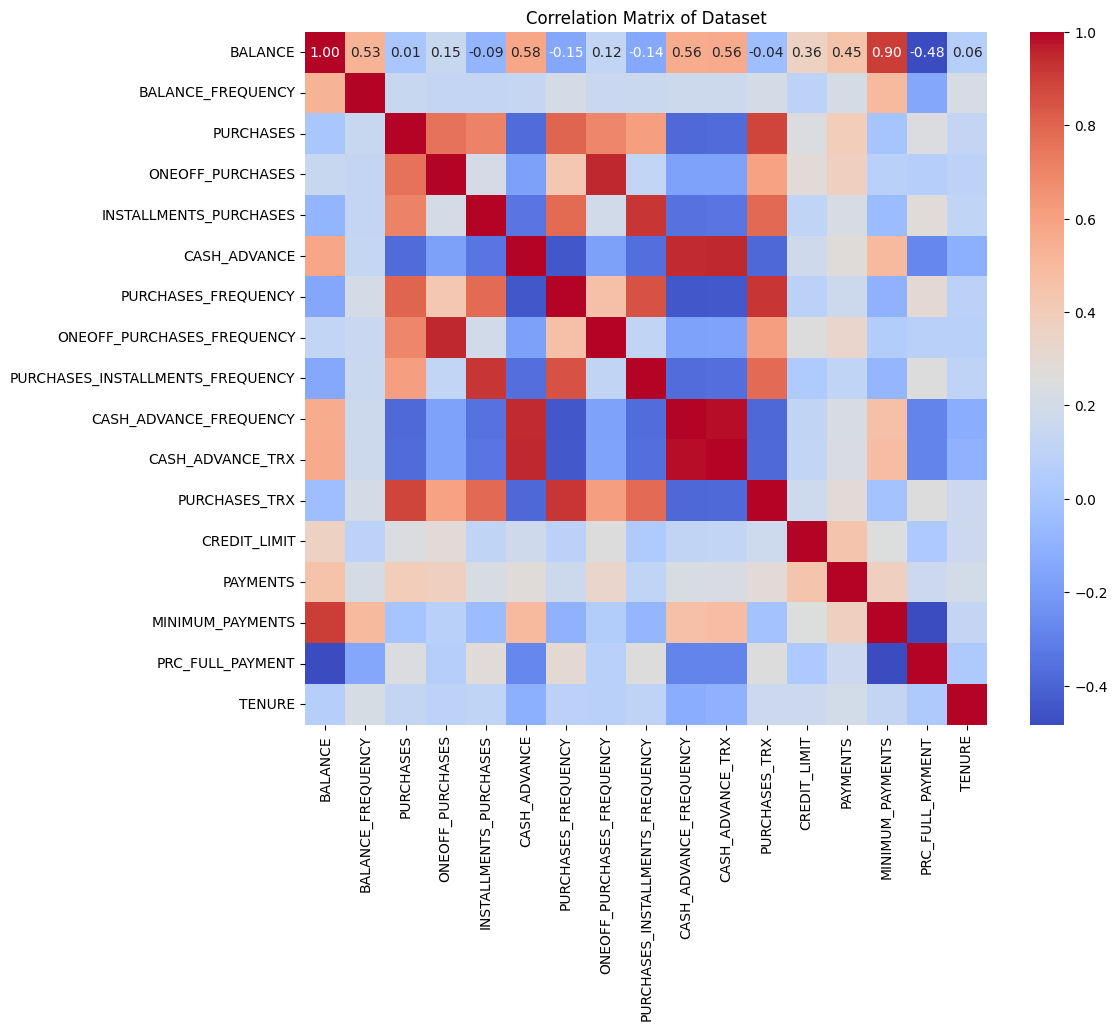

In [13]:
# Mengatur ukuran visualisasi
plt.figure(figsize=(11,9))

# Membuat heatmap dengan angka korelasi
sns.heatmap(df.corr(method='spearman'), annot=True, fmt=".2f", cmap='coolwarm') # menggunakan method karena terdaapat kolom skew

# Memberikan judul untuk heatmap
plt.title('Correlation Matrix of Dataset')

# Menampilkan grafik
plt.show()

**Berdasarkan heatmap diatas, terdapat hubungan antara 16 variabel yang dianalisis.**

* **Warna merah** menunjukkan hubungan positif yang kuat.
* **Warna putih** menunjukkan tidak ada hubungan.
* **Warna biru** menunjukkan hubungan negatif yang kuat.

**Beberapa hubungan yang menarik dalam heatmap ini adalah:**

* `ONEOFF_PURCHASE_FREQUENCY` dan `ONEOFF_PURCHASES`: Semakin sering pembelian sekali jalan dilakukan, semakin tinggi total nilai pembelian tersebut.  
* `CASH_ADVANCE` dengan `CASH_ADVANCE_FREQUENCY` dan `CASH_ADVANCE_TRX`: Frekuensi dan jumlah transaksi uang muka yang tinggi berkorelasi dengan total uang muka yang lebih besar.
* `PURCHASES` dan `PURCHASES_TRX`: Pembelian yang lebih sering dan dalam jumlah banyak berkaitan dengan total pembelian yang lebih besar.  
* `BALANCE` dan `PRC_FULL_PAYMENT`: Saldo yang lebih tinggi berkaitan dengan kecenderungan lebih rendah untuk membayar tagihan secara penuh.  
* `PRC_FULL_PAYMENT` dan `MINIMUM_PAYMENTS`: Pembayaran minimum yang lebih tinggi berkaitan dengan pembayaran penuh yang lebih rendah.  

## 2. Melihat lebih detail pada scaterplot setelah melihat hasil heatmap diatas

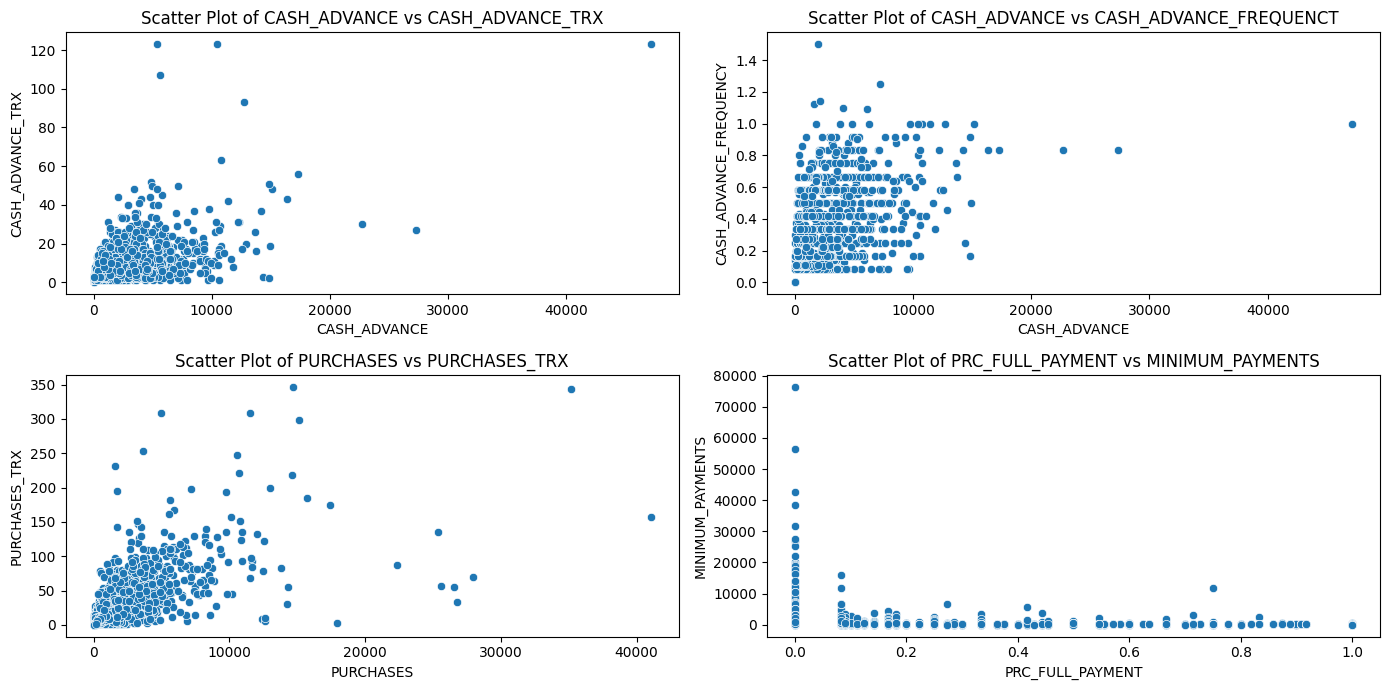

In [14]:
plt.figure(figsize=(14, 7))

plt.subplot(2,2,1)
sns.scatterplot(x='CASH_ADVANCE', y='CASH_ADVANCE_TRX', data=df)
plt.title('Scatter Plot of CASH_ADVANCE vs CASH_ADVANCE_TRX')

plt.subplot(2,2,2)
sns.scatterplot(x='CASH_ADVANCE', y='CASH_ADVANCE_FREQUENCY', data=df)
plt.title('Scatter Plot of CASH_ADVANCE vs CASH_ADVANCE_FREQUENCT')

plt.subplot(2,2,3)
sns.scatterplot(x='PURCHASES', y='PURCHASES_TRX', data=df)
plt.title('Scatter Plot of PURCHASES vs PURCHASES_TRX')

plt.subplot(2,2,4)
sns.scatterplot(x='PRC_FULL_PAYMENT', y='MINIMUM_PAYMENTS', data=df)
plt.title('Scatter Plot of PRC_FULL_PAYMENT vs MINIMUM_PAYMENTS')

plt.tight_layout()
plt.show()


**Scatter Plot 1: CASH_ADVANCE vs CASH_ADVANCE_TRX**  
pelanggan yang mengambil uang tunai dalam jumlah besar cenderung memiliki lebih banyak transaksi uang tunai.

**Scatter Plot 2: CASH_ADVANCE vs CASH_ADVANCE_FREQUENCY**  
penarikan tunai dalam jumlah besar cenderung lebih sering melakukan transaksi penarikan tunai.

**Scatter Plot 3: PURCHASES vs PURCHASES_TRX**  
pelanggan yang melakukan pembelian lebih besar cenderung melakukan lebih banyak transaksi.

**Scatter Plot 4: PRC_FULL_PAYMENT vs MINIMUM_PAYMENTS**  
persentase pembayaran penuh yang lebih tinggi cenderung memiliki pembayaran minimum yang lebih rendah.

## 3. Menampilkan seberapa sering uang tunai di muka dibayarkan dengan jumlah Transaksi yang dilakukan dengan "Cash in Advanced"

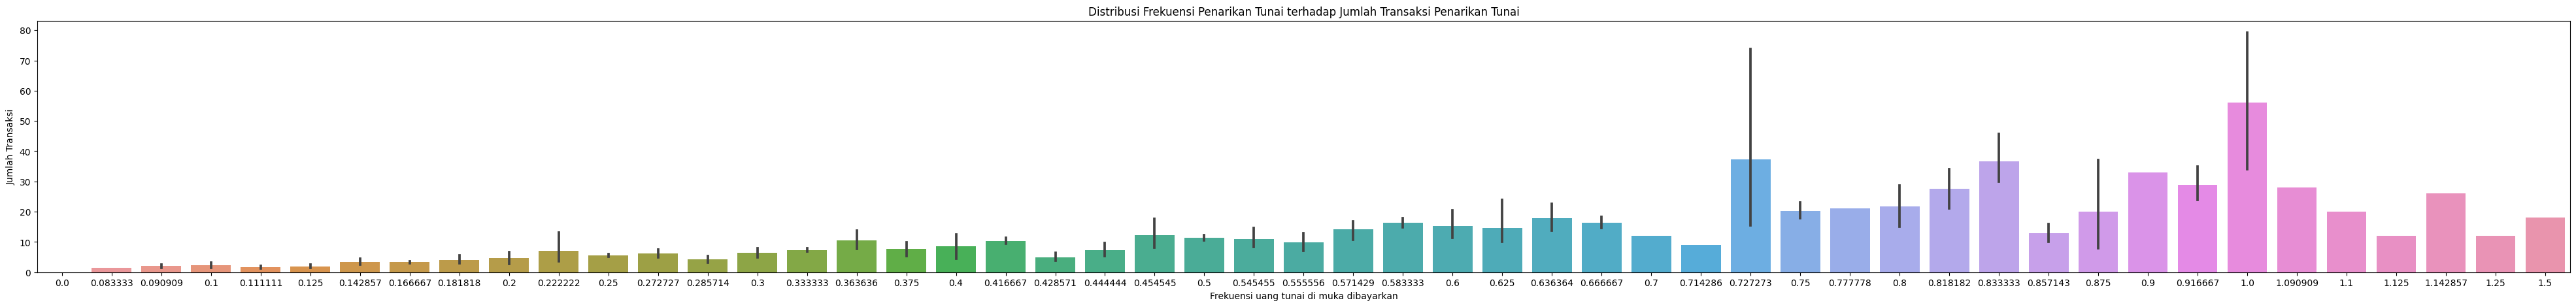

In [15]:
# Bar plot untuk melihat distribusi variabel kategorikal
plt.figure(figsize=(50, 5))
sns.barplot(data=df, x='CASH_ADVANCE_FREQUENCY', y='CASH_ADVANCE_TRX')
plt.title('Distribusi Frekuensi Penarikan Tunai terhadap Jumlah Transaksi Penarikan Tunai')
plt.xlabel('Frekuensi uang tunai di muka dibayarkan')
plt.ylabel('Jumlah Transaksi')
plt.show()

Pada grafik dapat diketahui bahwa semakin sering uang tunai di muka dibayarkan, semakin besar jumlah transaksi.

## 4. Melihat hubungan anatra dua variable yang lain dengan scaterplot.

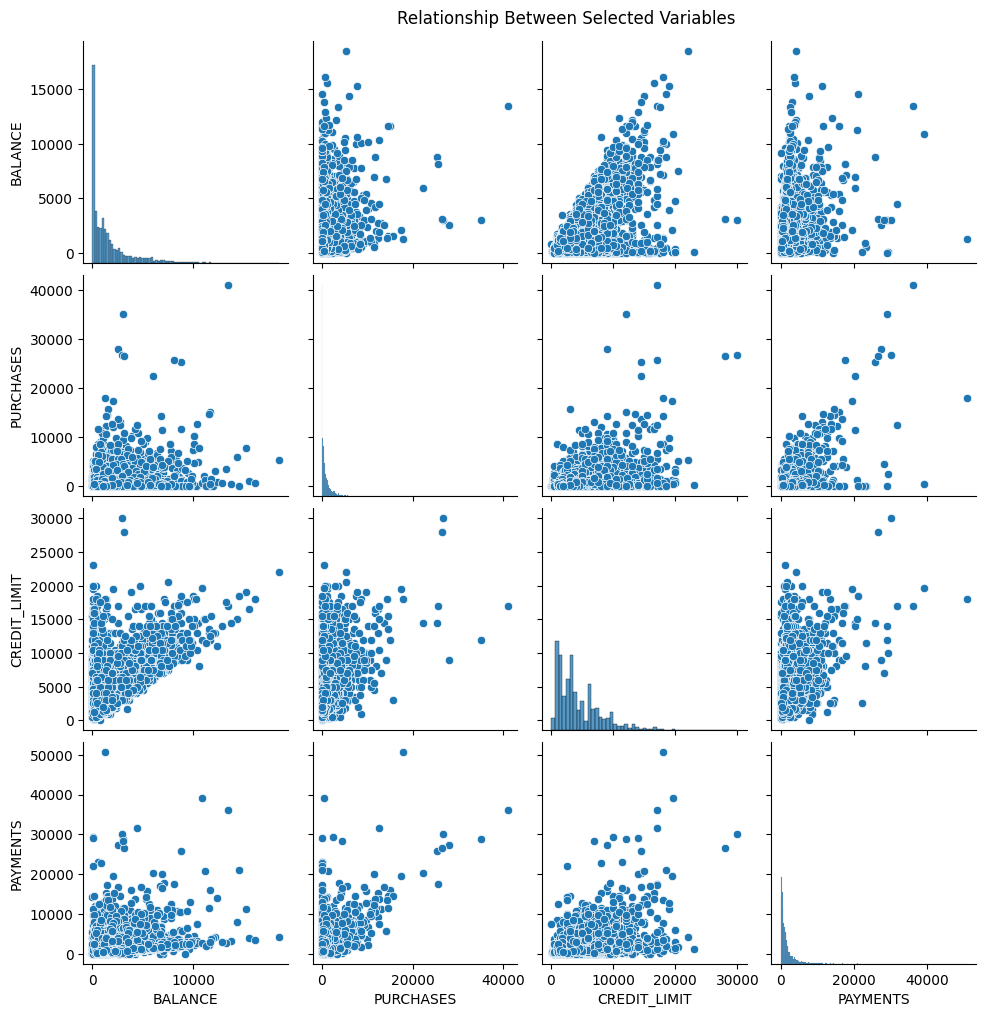

In [16]:
# It's usually better to select a few relevant columns to avoid a crowded pair plot
sns.pairplot(df[['BALANCE','PURCHASES','CREDIT_LIMIT','PAYMENTS']])
plt.title('Relationship Between Selected Variables', x = -1, y=4.2)
plt.show()

**Scatter Plot 1: BALANCE vs PURCHASES**  
Pembelian cenderung rendah saat saldo bervariasi dari rendah hingga tinggi.

**Scatter Plot 2: BALANCE vs CREDIT LIMIT**  
Saldo tinggi berkorelasi dengan batas kredit yang tinggi.

**Scatter Plot 3: BALANCE vs PAYMENTS**  
Pembayaran cenderung rendah saat saldo bervariasi dari rendah hingga tinggi.

**Scatter Plot 4: PURCHASES vs CREDIT LIMIT**  
Batas kredit yang tinggi sering terjadi dengan pembelian yang rendah.

**Scatter Plot 5: PURCHASES vs PAYMENTS**  
Pembayaran dan pembelian cenderung rendah.

**Scatter Plot 6: CREDIT LIMIT vs PAYMENTS**  
Batas kredit tinggi umumnya terjadi dengan pembayaran yang rendah.

## 5. Setelah melihat hubungan antar variable, kemudian saya ingin menampilkan variasi dan jumlah balance, purchases, credit limit, dan payments

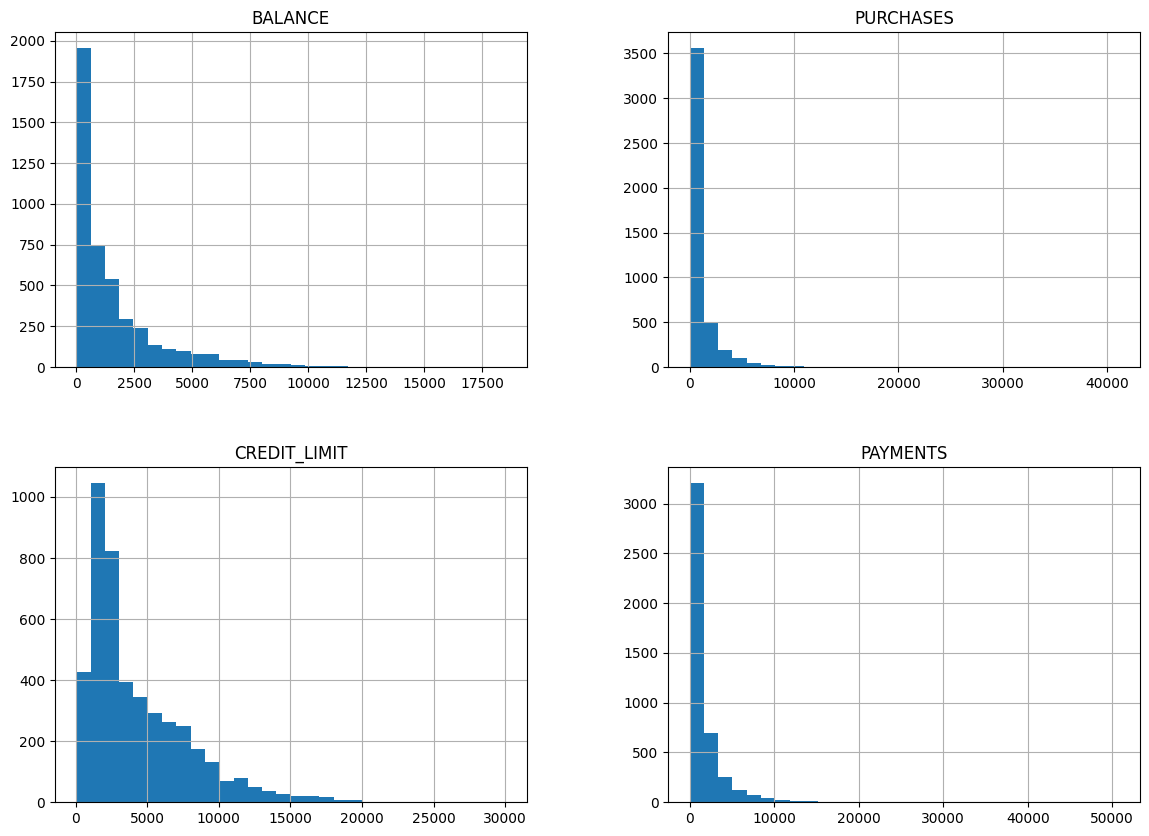

In [17]:
df[['BALANCE', 'PURCHASES', 'CREDIT_LIMIT', 'PAYMENTS']].hist(bins=30, figsize=(14, 10))
plt.show()

* **BALANCE**: Balance bervariasi. Pada grafik lebih banyak orang yang memiliki balance sedikit.  
* **PURCHASES**: Purchases bervariasi. Pada grafik lebih banyak orang yang memiliki purchases sedikit.  
* **CREDIT LIMIT**: Credit limit bervariasi. Pada grafik lebih banyak orang yang memiliki credit limit sedikit.   
* **PAYMENTS**: Payments bervariasi. Pada grafik lebih banyak orang yang memiliki payments sedikit.    

## 6. Tenure of credit card service for user

Yang terakhir, saya ingin melihat berapa lama kepemilikan kartu kredit bagi pengguna

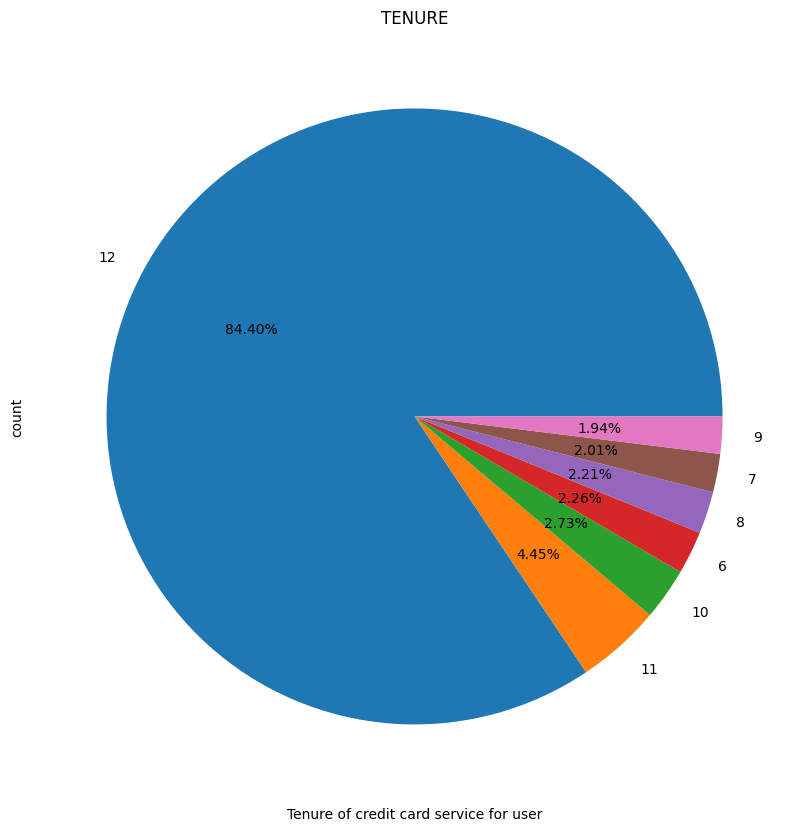

In [18]:
# membuat figure dan axis
fig,ax1 = plt.subplots(figsize=(10,10))

# plot data ke grafik
df['TENURE'].value_counts().plot(kind='pie', autopct='%.2f%%',ax=ax1)

# menambahkan title
plt.title('TENURE')
plt.xlabel('Tenure of credit card service for user')

# menampilkan grafik
plt.show()

Tenure paling banyak adalah 12 bulan sebanyak 84,70%, kemudian 11 bulan sebanyak 4,45%, kemudian 10 bulan sebanyak 2,73%, 6 bulan sebanyak 2,26%, 8 bulan sebanyak 2,21%, 7 bulan sebanyak 2,01%, dan 9 bulan sebanyak 1,94%

# vi. Feature Engineering

melakukan persiapan data untuk nantinya dibuat model

## Missing Value Handling

yang pertama mengecek apakah ada missing value.

In [19]:
# mengecek missing value
df.isnull().sum()

BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          0
PAYMENTS                              0
MINIMUM_PAYMENTS                    155
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

Terdapat 155 missing value pada `MINIMUM_PAYMENTS`, kemudian saya akan menghandling missing value tersebut.

Setelah melihat data pada tabel, data missing value terdapat secara acak atau randeom (MCAR) karena ketidak sengajaan tidak mengisi data tersebut. Oleh karena itu saya akan mengisi missing value tersebut dengan median dari kolom karena kolom terdistribusi skew.

In [20]:
# Display Median Value for Variables that have Missing Values

med = df['MINIMUM_PAYMENTS'].median()

df['MINIMUM_PAYMENTS'].fillna(med, inplace=True)

In [21]:
# mengecek missing value yang sudah di impute
df.isnull().sum()

BALANCE                             0
BALANCE_FREQUENCY                   0
PURCHASES                           0
ONEOFF_PURCHASES                    0
INSTALLMENTS_PURCHASES              0
CASH_ADVANCE                        0
PURCHASES_FREQUENCY                 0
ONEOFF_PURCHASES_FREQUENCY          0
PURCHASES_INSTALLMENTS_FREQUENCY    0
CASH_ADVANCE_FREQUENCY              0
CASH_ADVANCE_TRX                    0
PURCHASES_TRX                       0
CREDIT_LIMIT                        0
PAYMENTS                            0
MINIMUM_PAYMENTS                    0
PRC_FULL_PAYMENT                    0
TENURE                              0
dtype: int64

missing value sudah di handle, kemudian saya akan melakukan outliers handling.

## Ouliers Handling

In [22]:
# melihat berapa unique value
df.nunique()

BALANCE                             4433
BALANCE_FREQUENCY                     43
PURCHASES                           3203
ONEOFF_PURCHASES                    2093
INSTALLMENTS_PURCHASES              2292
CASH_ADVANCE                        2169
PURCHASES_FREQUENCY                   46
ONEOFF_PURCHASES_FREQUENCY            45
PURCHASES_INSTALLMENTS_FREQUENCY      47
CASH_ADVANCE_FREQUENCY                51
CASH_ADVANCE_TRX                      52
PURCHASES_TRX                        150
CREDIT_LIMIT                         158
PAYMENTS                            4362
MINIMUM_PAYMENTS                    4320
PRC_FULL_PAYMENT                      47
TENURE                                 7
dtype: int64

In [23]:
# menampilkan nama kolom
df.columns

Index(['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES',
       'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY',
       'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY',
       'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX',
       'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT',
       'TENURE'],
      dtype='object')

In [24]:
# memisahkan kolom numerical dan kategorical

num_col_1 = ['BALANCE', 'PURCHASES',
'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE',
'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 
'CREDIT_LIMIT', 'PAYMENTS','MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT']

cat_col = ['BALANCE_FREQUENCY', 'PURCHASES_FREQUENCY', 
'ONEOFF_PURCHASES_FREQUENCY','PURCHASES_INSTALLMENTS_FREQUENCY','CASH_ADVANCE_FREQUENCY']

num_col = ['BALANCE', 'PURCHASES',
'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE',
'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 
'CREDIT_LIMIT', 'PAYMENTS','MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE']

hanya menghandling outliers pada kolom numerical dan yang nuniquenya banyak, yaitu kolom `['BALANCE', 'PURCHASES',
'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE',
'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 
'CREDIT_LIMIT', 'PAYMENTS','MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT']`. Kemudian mengecek jenis outliers nya.

In [25]:
# penampungan data
normal =[]
skew = []
extreme_skew = []

# membuat kondisi pengecekan skew data.
for i in num_col_1:
    skewness = df[i].skew()
    if -0.5 < skewness < 0.5:
        normal.append(i)
    elif -1 <= skewness <= -0.5 or 0.5 <= skewness <= 1:
        skew.append(i)
    elif skewness < -1 or skewness > 1:
        extreme_skew.append(i)

print('normal:',normal)
print('skew:',skew)
print('extreme_skew:',extreme_skew)

normal: []
skew: []
extreme_skew: ['BALANCE', 'PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT']


kemudian diketahui semua jenis data merupakan extreme skew. Setelah itu saya melihat berapa outliers yang terdapat pada data.

In [26]:
#  function
# skew
def find_skewed_boundaries(df, variable, distance):
    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)
    lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
    upper_boundary = df[variable].quantile(0.75) + (IQR * distance)
    return upper_boundary, lower_boundary

def calculate_outliers_percentage(df, variable, distance):    
    upper_boundary, lower_boundary = find_skewed_boundaries(df, variable, distance)
    outliers = df[(df[variable] < lower_boundary) | (df[variable] > upper_boundary)]
    per = (len(outliers) / len(df)) * 100
    print('Percentage of outliers in {}: {:.2f}%'.format(variable, per))

In [27]:
# menampilkan percentage before ouliers handling 
for col in extreme_skew:
    calculate_outliers_percentage(df, col, 3)

Percentage of outliers in BALANCE: 2.08%
Percentage of outliers in PURCHASES: 4.65%
Percentage of outliers in ONEOFF_PURCHASES: 6.41%
Percentage of outliers in INSTALLMENTS_PURCHASES: 4.83%
Percentage of outliers in CASH_ADVANCE: 5.36%
Percentage of outliers in CASH_ADVANCE_TRX: 4.22%
Percentage of outliers in PURCHASES_TRX: 4.22%
Percentage of outliers in CREDIT_LIMIT: 0.09%
Percentage of outliers in PAYMENTS: 4.65%
Percentage of outliers in MINIMUM_PAYMENTS: 5.47%
Percentage of outliers in PRC_FULL_PAYMENT: 12.13%


setelah melihat percentage of outliers, terdapat beberapa kolom yang memiliki outliers lebih dari 5% sehingga saya akan melakukan capping untuk menghandle outliers semua kolom.

In [28]:
# capping the normal distribution

winsoriser_extreme_skew = Winsorizer(capping_method='iqr',
                             tail='both',
                             fold=3, ## karena extreme
                             variables=extreme_skew)

# menggunakan winsorizer untuk mengatasi outlier pada df
df_cap = winsoriser_extreme_skew.fit_transform(df)

In [29]:
# menampilkan percentage after ouliers handling 
for col in extreme_skew:
    calculate_outliers_percentage(df_cap, col, 3)

Percentage of outliers in BALANCE: 0.00%
Percentage of outliers in PURCHASES: 0.00%
Percentage of outliers in ONEOFF_PURCHASES: 0.00%
Percentage of outliers in INSTALLMENTS_PURCHASES: 0.00%
Percentage of outliers in CASH_ADVANCE: 0.00%
Percentage of outliers in CASH_ADVANCE_TRX: 0.00%
Percentage of outliers in PURCHASES_TRX: 0.00%
Percentage of outliers in CREDIT_LIMIT: 0.00%
Percentage of outliers in PAYMENTS: 0.00%
Percentage of outliers in MINIMUM_PAYMENTS: 0.00%
Percentage of outliers in PRC_FULL_PAYMENT: 0.00%


setelah handling outliers, percentage of outliers menjadi 0%.

## Spliting between numerical and categorical

setelah menghandle missing value dan outlier, saya akan memisahkan numerical dan categorical kolom

In [30]:
# split numerical dan categorical based on column types
df_num = df_cap[num_col_1]

df_cat = df_cap[cat_col]

df_num.head()

,BALANCE,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT
0,3.833185,45.00,45.00,0.0,0.0,0,1,500.0,0.000000,313.980229,0.0
1,0.000000,176.03,176.03,0.0,0.0,0,1,7000.0,0.000000,313.980229,0.0
2,757.964752,157.40,157.40,0.0,0.0,0,6,1200.0,1494.480376,2632.441186,0.0
3,264.566591,1150.00,1150.00,0.0,0.0,0,1,1200.0,3029.380326,85.428885,0.0
4,440.613643,600.00,600.00,0.0,0.0,0,1,1000.0,215.316424,137.846006,0.0


## Concate kolom

setelah scaling numerical kolom, saya akan menggabungkan kolom numerical

In [31]:
df_tenure = df['TENURE']
df_tenure

0        8
1        8
2        8
3        8
4        8
        ..
4470    11
4471    11
4472    11
4473    11
4474    11
Name: TENURE, Length: 4475, dtype: int64

In [32]:
df_num

,BALANCE,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT
0,3.833185,45.00,45.00,0.0,0.000000,0,1,500.0,0.000000,313.980229,0.0
1,0.000000,176.03,176.03,0.0,0.000000,0,1,7000.0,0.000000,313.980229,0.0
2,757.964752,157.40,157.40,0.0,0.000000,0,6,1200.0,1494.480376,2632.441186,0.0
3,264.566591,1150.00,1150.00,0.0,0.000000,0,1,1200.0,3029.380326,85.428885,0.0
4,440.613643,600.00,600.00,0.0,0.000000,0,1,1000.0,215.316424,137.846006,0.0
...,...,...,...,...,...,...,...,...,...,...,...
4470,7816.984649,0.00,0.00,0.0,4372.393835,9,0,12000.0,2468.988022,2134.295731,0.0
4471,1040.030221,0.00,0.00,0.0,1390.648290,16,0,1400.0,290.129620,287.994171,0.0
4472,1322.818587,0.00,0.00,0.0,762.301096,11,0,1500.0,1035.627320,312.835530,0.0
4473,1060.391273,0.00,0.00,0.0,1475.858013,10,0,2000.0,407.360560,277.084736,0.0


In [33]:
# menggabungkan
df_final = pd.concat([df_num, df_tenure],axis=1)
df_final

,BALANCE,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,3.833185,45.00,45.00,0.0,0.000000,0,1,500.0,0.000000,313.980229,0.0,8
1,0.000000,176.03,176.03,0.0,0.000000,0,1,7000.0,0.000000,313.980229,0.0,8
2,757.964752,157.40,157.40,0.0,0.000000,0,6,1200.0,1494.480376,2632.441186,0.0,8
3,264.566591,1150.00,1150.00,0.0,0.000000,0,1,1200.0,3029.380326,85.428885,0.0,8
4,440.613643,600.00,600.00,0.0,0.000000,0,1,1000.0,215.316424,137.846006,0.0,8
...,...,...,...,...,...,...,...,...,...,...,...,...
4470,7816.984649,0.00,0.00,0.0,4372.393835,9,0,12000.0,2468.988022,2134.295731,0.0,11
4471,1040.030221,0.00,0.00,0.0,1390.648290,16,0,1400.0,290.129620,287.994171,0.0,11
4472,1322.818587,0.00,0.00,0.0,762.301096,11,0,1500.0,1035.627320,312.835530,0.0,11
4473,1060.391273,0.00,0.00,0.0,1475.858013,10,0,2000.0,407.360560,277.084736,0.0,11


## Scaling

setelah menggabungkan kolom numerical, saya akan mengscaling numerical kolom. Karena kolom numericalnya adalah extreme skew, maka saya menggunakan MinxMaxScaler untuk mengscaling.

In [34]:
# Feature scaling
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df_final)

# menampilkan
scaled

array([[4.90366193e-04, 1.04870660e-02, 1.95577344e-02, ...,
        1.19266996e-01, 0.00000000e+00, 3.33333333e-01],
       [0.00000000e+00, 4.10230715e-02, 7.65055109e-02, ...,
        1.19266996e-01, 0.00000000e+00, 3.33333333e-01],
       [9.69638276e-02, 3.66814262e-02, 6.84086089e-02, ...,
        1.00000000e+00, 0.00000000e+00, 3.33333333e-01],
       ...,
       [1.69223639e-01, 0.00000000e+00, 0.00000000e+00, ...,
        1.18832149e-01, 0.00000000e+00, 8.33333333e-01],
       [1.35652214e-01, 0.00000000e+00, 0.00000000e+00, ...,
        1.05251199e-01, 0.00000000e+00, 8.33333333e-01],
       [4.41049123e-01, 4.77744116e-02, 8.90963457e-02, ...,
        3.10674159e-01, 0.00000000e+00, 8.33333333e-01]])

## PCA

setelah scaling saya mereduksi features dengan PCA sebelum di buat modelnya

In [35]:
# Dimensionality Reduction using PCA
pca = PCA()
pca.fit(scaled)

PCA()

Text(0, 0.5, 'Explained Variance Ratio - Cummulative')

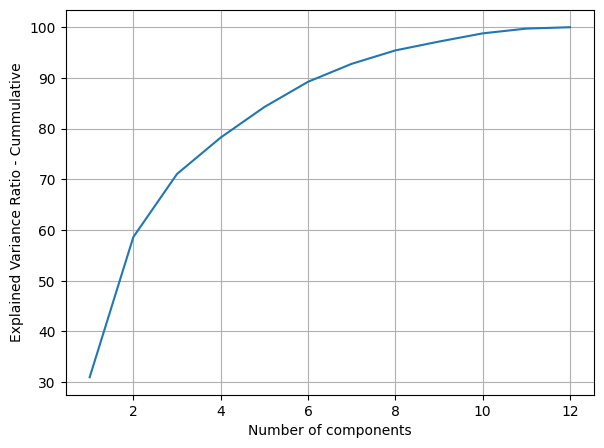

In [36]:
# Plot the Cummulative of Explained Variance Ratio
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.grid()
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel('Number of components')
plt.ylabel('Explained Variance Ratio - Cummulative')

Dari grafik 8 features masih diatas 95% jadi kemungkinan memakai 8 features, dipastikan lagi dengan menghitung langsung.

In [37]:
# Check the number of features if we want to retain 95 % of the information

cumsum = np.cumsum(pca.explained_variance_ratio_)
num_features = np.argmax(cumsum >= 0.95) + 1
num_features

8

setelah dihitung `8` features yang bisa dipakai dari 12 feature. Kemudian saya akan train the model with 8 features

In [38]:
# train the model with 95 % of the original dataset information

pca = PCA(n_components=0.95, random_state = 7)
pca.fit(scaled)

df_final_pca = pca.transform(scaled)

# vii. Model Definition

Find the optimal numbers of clusters menggunakan 4 metode, yaitu elbow mehtod, inertia, silhouette score, dan silhouette visualitaion. Untuk memastikan hasil yang akurat

## Elbow

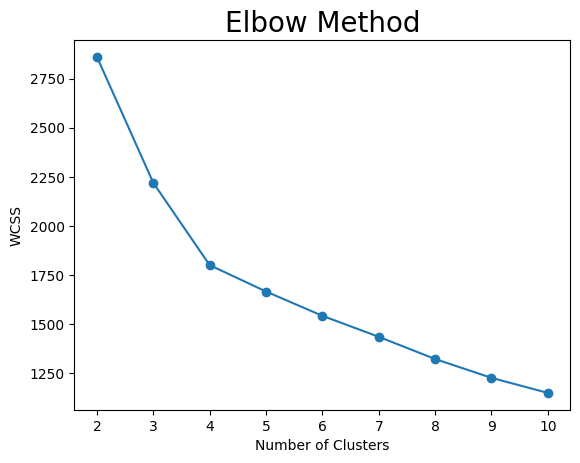

In [39]:
# Find the optimal number of clusters using Elbow Method

wcss = []
sil_score = []
random_state = 7
max_cluster = 10
for i in range(2, max_cluster+1):
    km = KMeans(n_clusters = i,
                init = 'k-means++',
                max_iter = 300,
                n_init = 10,
                random_state = random_state)
    km.fit(df_final_pca)
    wcss.append(km.inertia_)
    sil_score.append(silhouette_score(df_final_pca,km.labels_))

plt.plot(range(2, max_cluster+1), wcss, marker ="o")
# plt.grid()
plt.title('Elbow Method', fontsize = 20)
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

dari metode elbow kita lihat dan kira-kira K=3-6, jadi pas di silhouette kita liat di range segitu aja, trs liat nilai yang paling tinggi.

## Inertia

Text(0, 0.5, 'Inertia')

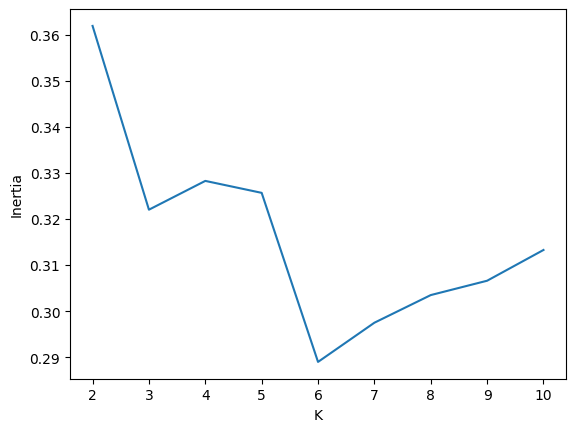

In [40]:
# Visualize the elbow
plt.plot(range(2, max_cluster+1),sil_score)
plt.xlabel('K')
plt.ylabel('Inertia')

Berdasarkan plot diatas K=2 itu paling tinggi Inertianya, akan tetapi saya hanya melihat dari k=3 sampai k=6. sehingga nilai paling tinggi adalah k=4.

## Silhouette Score dan Visualitation

In [41]:
# Function to create Silhouette Plot

def plot_silhouette(range_n_clusters, X, random_state):
    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 4)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters = n_clusters, init = 'k-means++', max_iter = 300, n_init = 10, random_state = random_state)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

        # Labeling the clusters
        centers = clusterer.cluster_centers_

        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

For n_clusters = 2 The average silhouette_score is : 0.36187329548245195
For n_clusters = 3 The average silhouette_score is : 0.32201862708626117
For n_clusters = 4 The average silhouette_score is : 0.3282633989906411
For n_clusters = 5 The average silhouette_score is : 0.3256712210477288
For n_clusters = 6 The average silhouette_score is : 0.2890057054123568
For n_clusters = 7 The average silhouette_score is : 0.2975088956224661
For n_clusters = 8 The average silhouette_score is : 0.3035019737412554
For n_clusters = 9 The average silhouette_score is : 0.3066138634708121


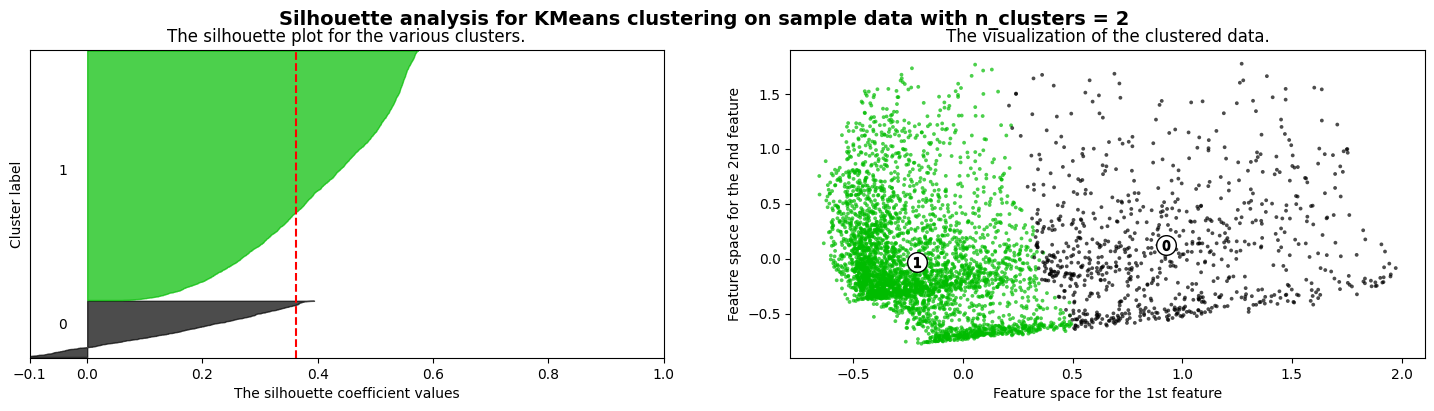

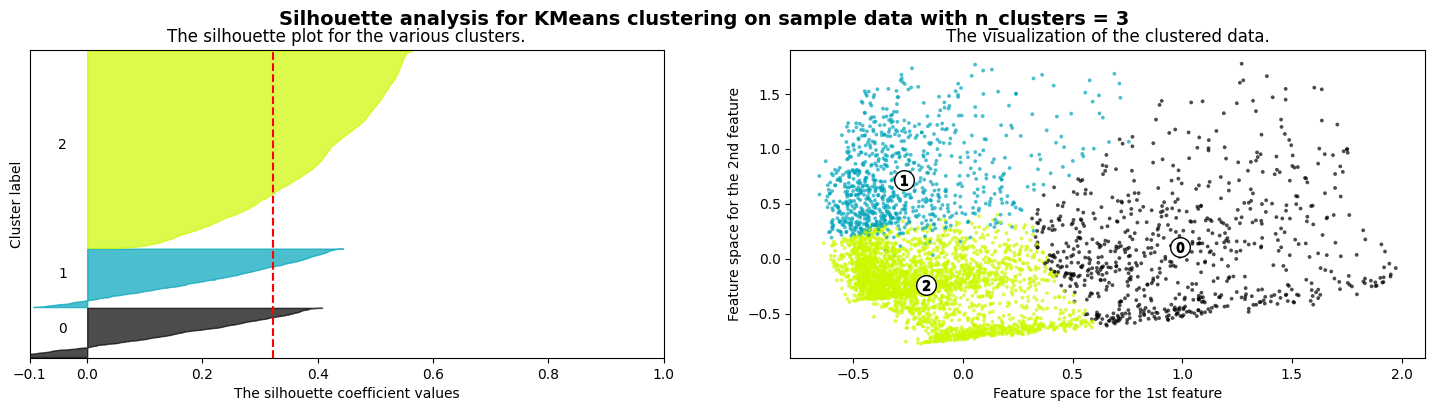

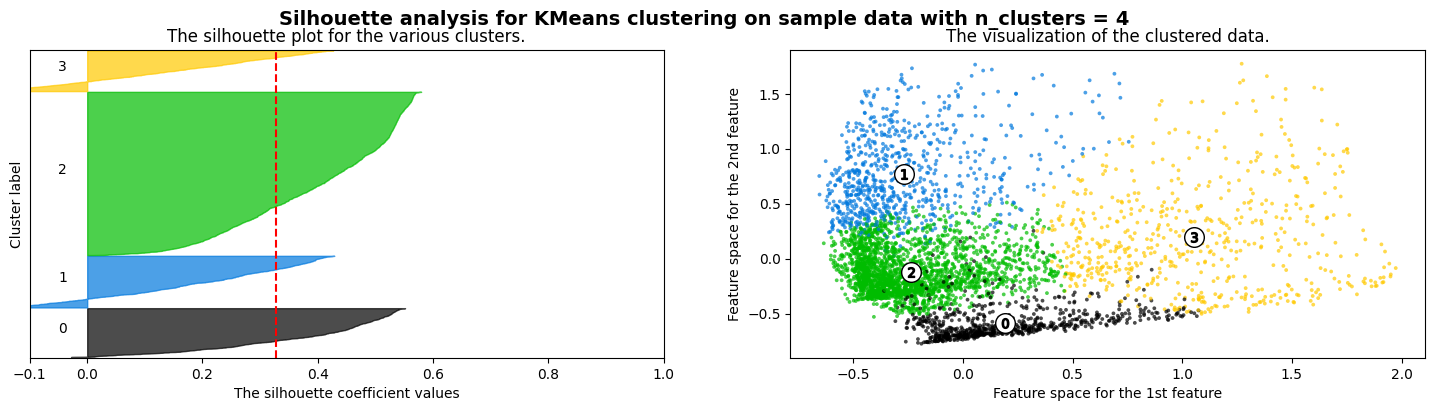

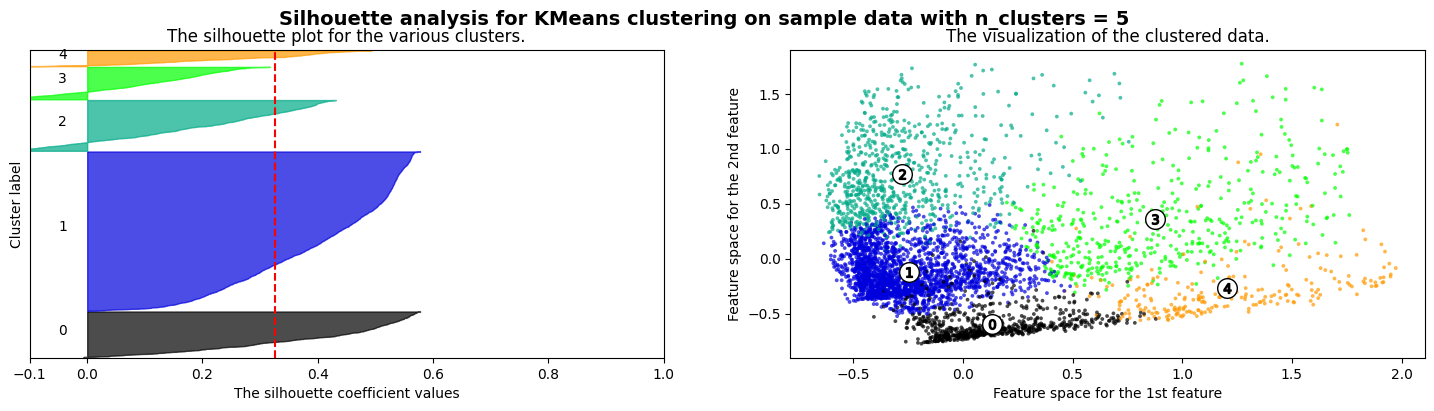

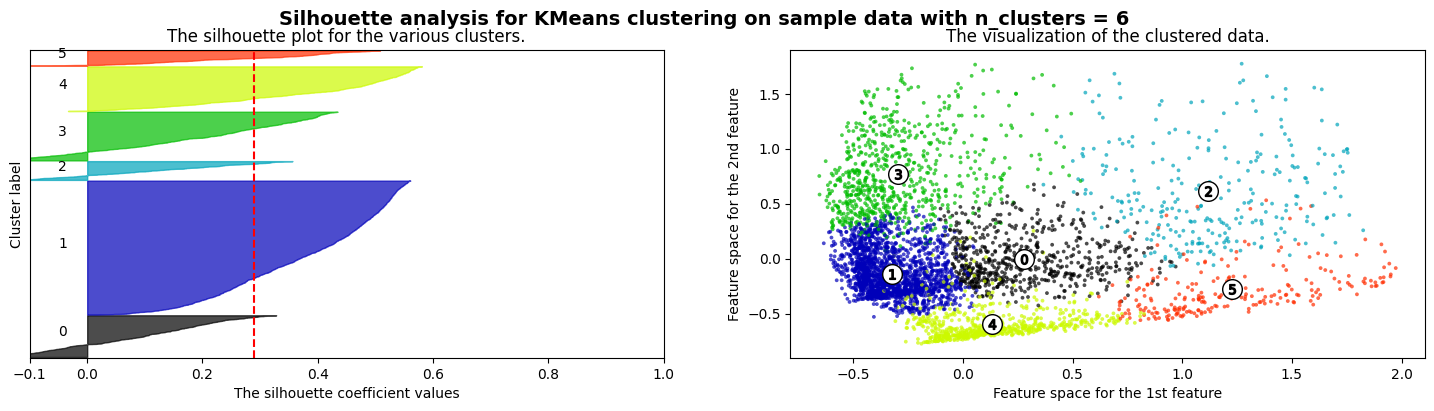

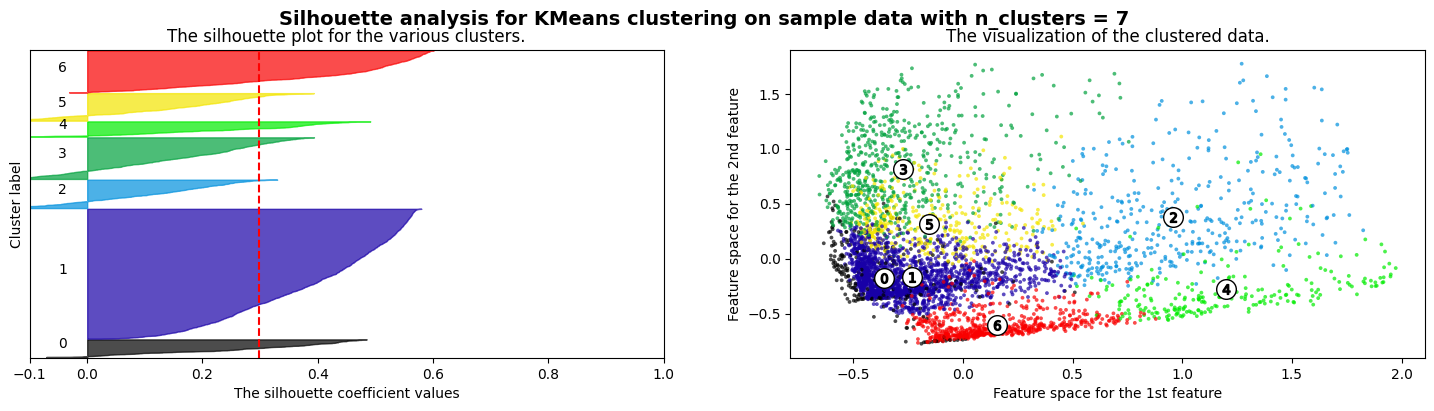

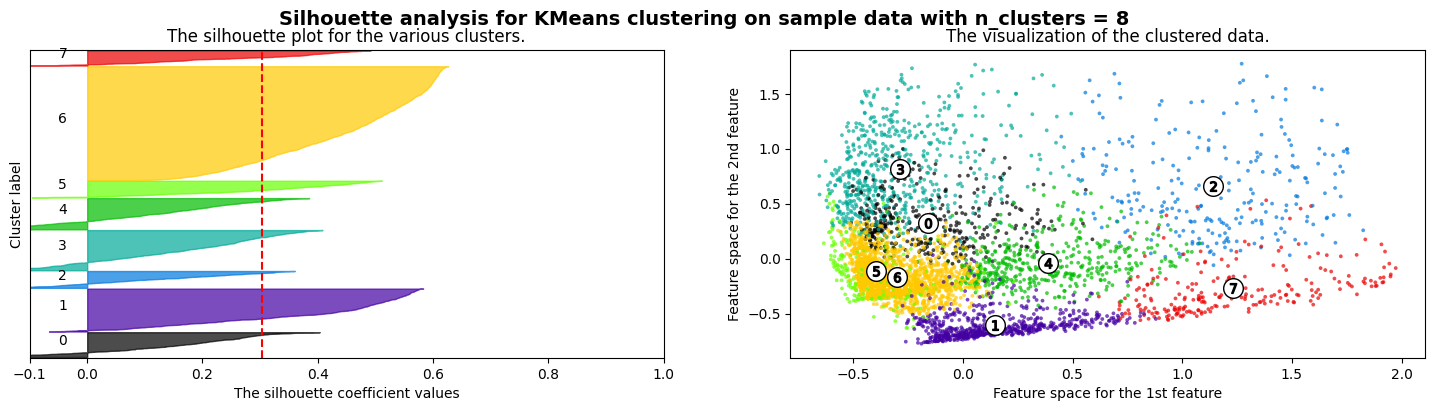

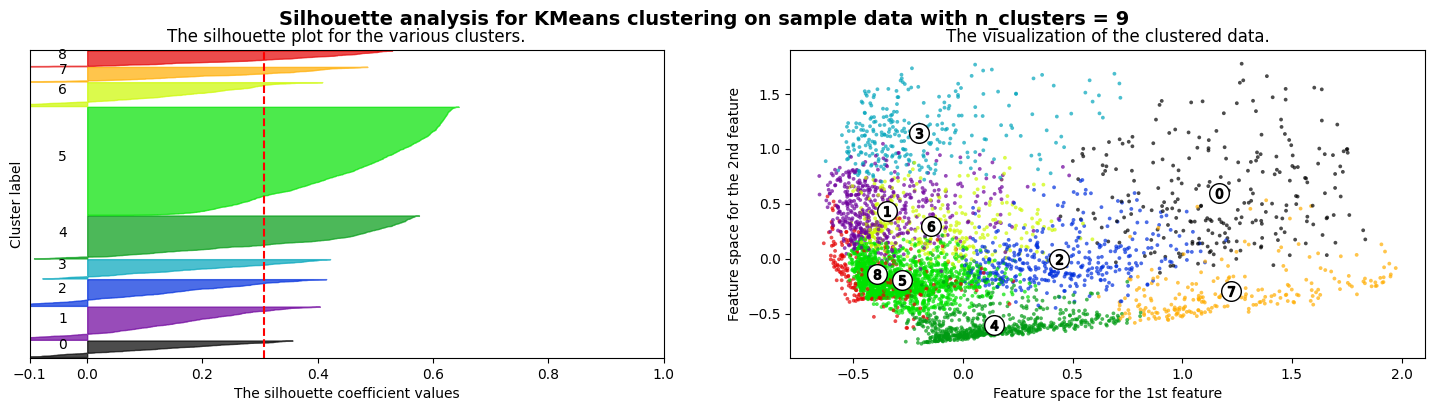

In [42]:
# Display the Silhouette Score and Plot Silhouette Plot

plot_silhouette(range(2, max_cluster), df_final_pca, random_state)

Dari metode silhouette score yang paling tinggi amtar K =3 sampai K 6 adalah K=4.

Dari grafik k=5 tidak sesuai kriteria yaitu ada yang tidak melebihi average  score, sehingga persebaran data yang lebih balance adalah k = 4.

# viii. Model Training

dari 4 metode diatas, saya memutuskan untuk memakai k=4 karena yang paling masuk akal dan paling memenuhi kriteria semua metode.

Kemudian saya melakukan model training dengan KMeans

In [43]:
# Train with optimal number of clusters

km = KMeans(n_clusters = 4, init = 'k-means++', max_iter = 300, n_init = 10, random_state = random_state)
pred = km.fit_predict(df_final_pca)
pred

array([2, 2, 2, ..., 2, 2, 1])

In [44]:
# Insert clustering result into original dataset

df_final['cluster'] = pred
df_final

,BALANCE,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,cluster
0,3.833185,45.00,45.00,0.0,0.000000,0,1,500.0,0.000000,313.980229,0.0,8,2
1,0.000000,176.03,176.03,0.0,0.000000,0,1,7000.0,0.000000,313.980229,0.0,8,2
2,757.964752,157.40,157.40,0.0,0.000000,0,6,1200.0,1494.480376,2632.441186,0.0,8,2
3,264.566591,1150.00,1150.00,0.0,0.000000,0,1,1200.0,3029.380326,85.428885,0.0,8,2
4,440.613643,600.00,600.00,0.0,0.000000,0,1,1000.0,215.316424,137.846006,0.0,8,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4470,7816.984649,0.00,0.00,0.0,4372.393835,9,0,12000.0,2468.988022,2134.295731,0.0,11,1
4471,1040.030221,0.00,0.00,0.0,1390.648290,16,0,1400.0,290.129620,287.994171,0.0,11,1
4472,1322.818587,0.00,0.00,0.0,762.301096,11,0,1500.0,1035.627320,312.835530,0.0,11,2
4473,1060.391273,0.00,0.00,0.0,1475.858013,10,0,2000.0,407.360560,277.084736,0.0,11,2


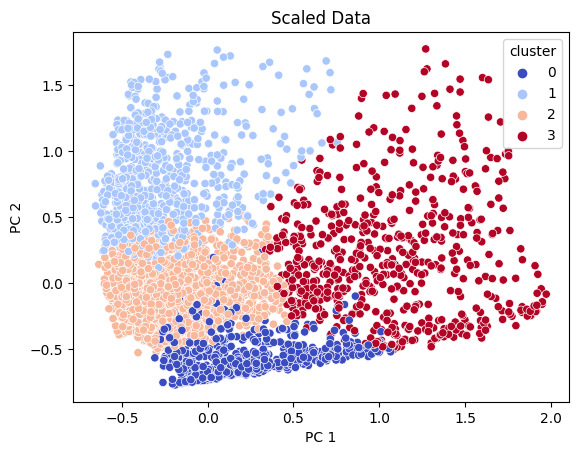

In [45]:
# Cluster visualization in 2D

pca_2d = PCA(n_components=2)
pca_2d.fit(df_final_pca)

sales_scaled_pca_2d = pca_2d.fit_transform(df_final_pca)

sns.scatterplot(x=sales_scaled_pca_2d[:,0], y=sales_scaled_pca_2d[:,1], hue=df_final['cluster'], palette='coolwarm')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('Scaled Data')
plt.show()

In [46]:
# Melakukan groupby berdasarkan cluster dan menghitung rata-rata
df_baru = df_final.groupby('cluster').mean().reset_index()

# Tampilkan DataFrame
df_baru

,cluster,BALANCE,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,0,103.619455,779.485535,275.840612,483.221627,93.300715,0.269819,14.251739,4286.995195,1031.320378,167.605469,0.450401,11.340751
1,1,3867.196126,346.632148,199.323676,143.796667,3180.064824,9.940711,6.065876,6689.817144,2547.750931,1318.414631,0.025417,11.440053
2,2,1007.568291,396.350179,222.554956,173.214802,370.509976,1.526469,7.356398,3194.314761,826.042830,488.189543,0.019793,11.508128
3,3,2297.580143,3316.765151,1730.482742,1058.464615,564.435503,1.861204,44.127090,7145.986622,3538.582983,868.457868,0.145600,11.871237


# ix. EDA after clustering

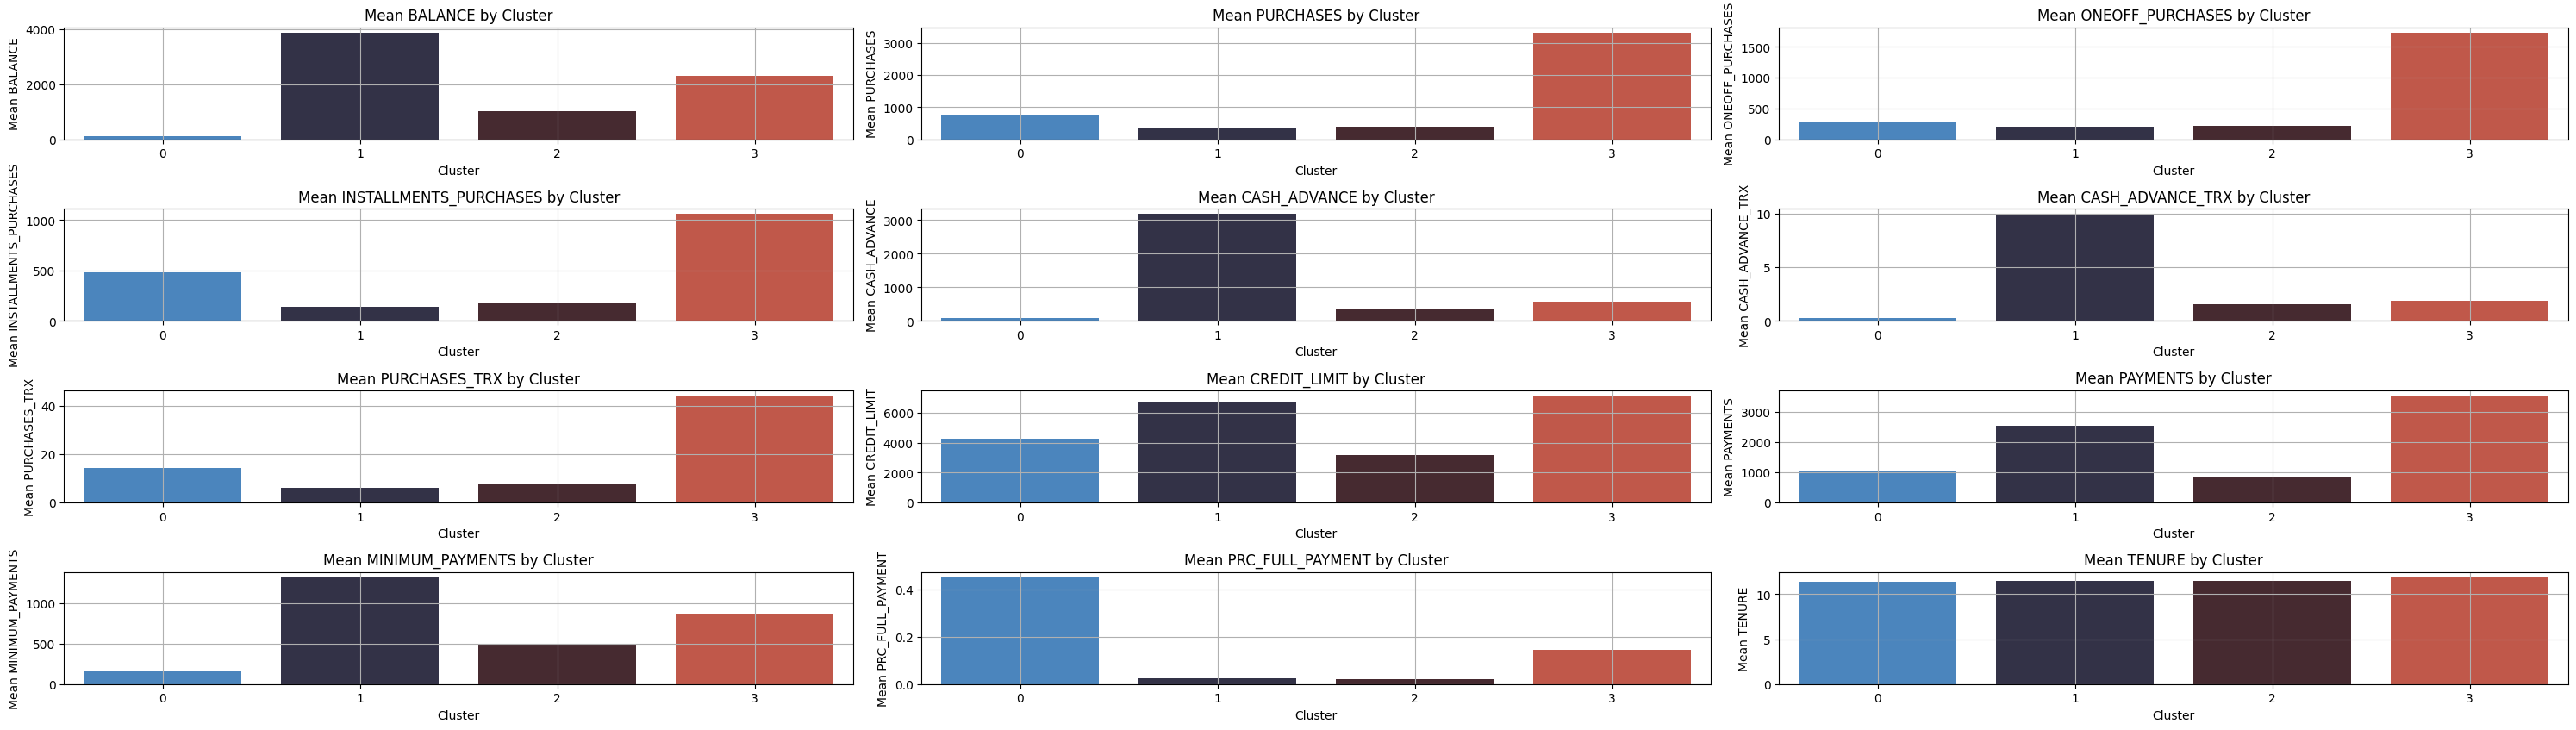

In [47]:
# Pengelompokan rata-rata untuk setiap fitur
features = ['BALANCE', 'PURCHASES', 'ONEOFF_PURCHASES',
       'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'CASH_ADVANCE_TRX',
       'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS',
       'PRC_FULL_PAYMENT', 'TENURE']
means_by_cluster = df_final.groupby('cluster')[features].mean().reset_index()

# Mengatur ukuran gambar dan membuat plot
plt.figure(figsize=(30,25))

for i, feature in enumerate(features, start=1):
    plt.subplot(12, 3, i)
    sns.barplot(data=means_by_cluster, x='cluster', y=feature, palette='icefire')
    plt.title(f'Mean {feature} by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel(f'Mean {feature}')
    plt.grid(True)

plt.tight_layout()
plt.show()

Dari grafik diatas, dapat disimpulkan tiap cluster:

cluster 0 = balance dan minimum payments sedang, installments purchases dan purchases trx rendah, purchases dan oneoff purchases rendah, cash advance dan cash advance trx rendah,
credit sedang, payments rendah, prc full payments rendah, tenure tinggi

cluster 1 = balance dan minimum payments tinggi, installments purchases dan purchases trx rendah, purchases dan oneoff purchases rendah, cash advance dan cash advance trx tinggi,
credit limit sedang, payments rendah, prc full payments rendah, tenure tinggi

cluster 2 = balance dan minimum payments rendah, installments purchases dan purchases trx sedang, purchases dan oneoff purchases sedang, cash advance dan cash advance trx rendah,
credit limit sedang, payments sedang, prc full payments tinggi, tenure tinggi

cluster 3 = balance dan minimum payments sedang, installments purchases dan purchases trx tinggi, purchases dan oneoff purchases tinggi, cash advance dan cash advance trx rendah,
credit limit tinggi, payments tinggi, prc full payments sedang, tenure tinggi

In [48]:
# list kosong untuk menyimpan kategori berdasarkan cluster
keterangan = []

# Loop melalui setiap cluster
for i in df_final['cluster']:
    if i == 0:
        keterangan.append('Moderate Spenders')
    elif i == 1:
        keterangan.append('High-Balance Spenders')
    elif i == 2:
        keterangan.append('Frugal Spenders')
    elif i == 3:
        keterangan.append('High-Volume Spenders')

# Menetapkan list `keterangan` ke kolom baru di DataFrame
df_final['cluster_keterangan'] = keterangan

Penjelasan untuk setiap nama cluster:

Cluster 0: **Moderate Spenders**: Cluster ini cenderung memiliki tingkat pengeluaran yang moderat dengan saldo dan pembayaran minimum yang sedang, serta pembelian dan transaksi rendah.
   
Cluster 1: **High-Balance Spenders**: Pelanggan dalam cluster ini memiliki saldo yang tinggi dan cenderung melakukan penarikan tunai dalam jumlah besar, meskipun jumlah pembelian dan transaksi rendah.

Cluster 2: **Frugal Spenders**: Cluster ini dikenali dengan saldo dan pembayaran minimum yang rendah, namun melakukan pembelian dengan frekuensi sedang serta pembayaran penuh yang tinggi.

Cluster 3: **High-Volume Spenders**: Pelanggan dalam cluster ini cenderung melakukan pembelian dan transaksi dalam jumlah besar, dengan kredit limit dan pembayaran yang tinggi, namun memiliki saldo dan pembayaran minimum yang sedang.

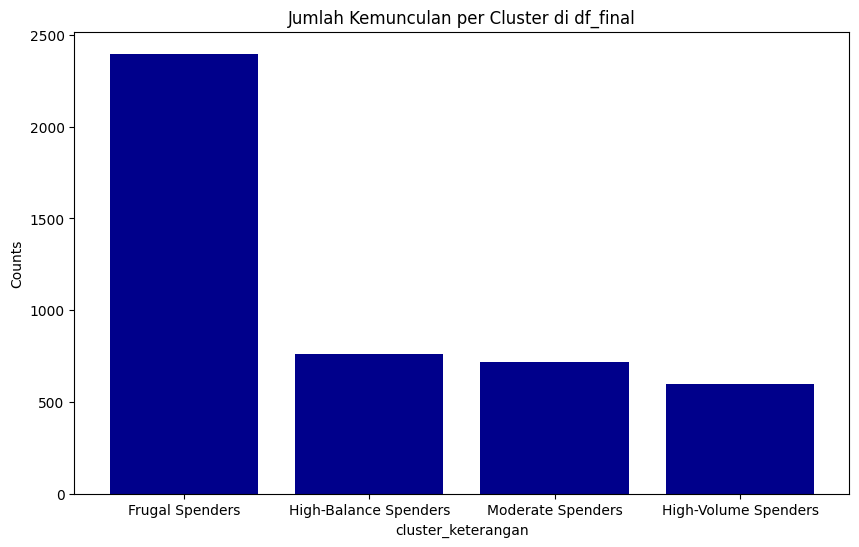

In [49]:
# Menghitung frekuensi masing-masing cluster
cluster_counts = df_final['cluster_keterangan'].value_counts().reset_index()
cluster_counts.columns = ['cluster_keterangan', 'counts']

# Membuat grafik batang
plt.figure(figsize=(10, 6))
plt.bar(cluster_counts['cluster_keterangan'], cluster_counts['counts'], color='darkblue')
plt.xlabel('cluster_keterangan')
plt.ylabel('Counts')
plt.title('Jumlah Kemunculan per Cluster di df_final')
plt.show()


In [50]:
# menampilkan frekuensi masing-masing cluster
cluster_counts

,cluster_keterangan,counts
0,Frugal Spenders,2399
1,High-Balance Spenders,759
2,Moderate Spenders,719
3,High-Volume Spenders,598


dapat dilihat pada grafik, paling banyak adalah cluster `Frugal Spender` dan paling sedikit adalah cluster `Hiigh-Balance Spenders`.

# x. Model Saving

setelah selesai model training, evaluation, dan saving selanjutnya adalah save model agar nanti dapat dibuat inferencenya.

In [51]:
with open('model_scaler.pkl', 'wb') as file_1:
  pickle.dump(scaler, file_1)

with open('model_pca.pkl', 'wb') as file_2:
  pickle.dump(pca, file_2)

with open('model_km.pkl', 'wb') as file_3:
  pickle.dump(km, file_3)

with open('num_col.txt','w') as file_4:
  json.dump(num_col,file_4)

# xi. Kesimpulan

Terdapat 4 cluster yaitu :  
**Moderate Spenders**  
**High-Balance Spenders**  
**Frugal Spenders**  
**High-Volume Spenders**   

>Model bekerja dengan baik dan sehingga dapat menentukan cluster dan menghasilkan output yang sesuai.

**Saran untuk model improvement:**  
metode pemilihan K sudah cukup banyak dan harusnya sudah cukup baik untuk mengetahui nilai k nya, mungkin menambahkan data tambahan seperti data demografis atau perilaku pengguna yang dapat meningkatkan pemahaman tentang profil pelanggan dan meningkatkan kualitas clustering.

**BISNIS INSIGHT :**

**Moderate Spenders**:  
Bank dapat menyediakan program insentif atau penawaran khusus untuk mendorong pembelian lebih lanjut kepada pelanggan dalam cluster ini. Layanan perbankan yang sesuai dengan kebutuhan mereka yang cenderung moderat dan konservatif juga dapat dikembangkan.

**High-Balance Spenders**:
Bank dapat menawarkan produk-produk investasi atau solusi keuangan yang lebih kompleks kepada pelanggan dalam cluster ini, seperti reksadana atau produk asuransi. Peningkatan fokus pada layanan perbankan pribadi yang eksklusif juga bisa dipertimbangkan. 

**Frugal Spenders**:
Bank dapat mengembangkan program pembayaran yang fleksibel dan penawaran diskon yang lebih menarik bagi pelanggan dalam cluster ini. Mendorong penggunaan layanan perbankan digital dan aplikasi perbankan yang mudah digunakan juga bisa menjadi strategi yang efektif.

**High-Volume Spenders**:
Bank dapat menawarkan produk-produk kredit yang lebih menguntungkan dan layanan prioritas bagi pelanggan dalam cluster ini. Program loyalitas yang eksklusif dan insentif untuk penggunaan kartu kredit juga bisa menjadi strategi yang efektif untuk mempertahankan kepuasan dan loyalitas pelanggan.

**Kelebihan dan kekurangan menggunakan model KMeans**: 

Kelebihan

1. Sederhana dan cocok untuk kumpulan data besar.

2. Dijamin konvergen dalam jumlah langkah yang terbatas (biasanya iterasi yang cukup kecil).

3. Salah satu algoritma pengelompokan tercepat.


Kekurangan

1. Peka terhadap tempat awal centroid, yang dapat menghasilkan hasil berbeda untuk inisialisasi berbeda.

2. Asumsikan cluster berbentuk bola, berukuran sama, dan memiliki kepadatan yang sama.

3. Jumlah cluster (K) perlu ditentukan terlebih dahulu sebelum clustering dimulai.

4. Sensitif terhadap outlier.

5. K-Means dirancang untuk fitur berkelanjutan. Ini mungkin tidak berfungsi dengan baik untuk fitur kategorikal yang telah menjalani pengkodean fitur.
